<a href="https://colab.research.google.com/github/DavidCastro88/ProjectsData/blob/main/FlightPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Flight Price Prediction***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Preprocessing data
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split

# ML Regresión
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

#Metricas Regression
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                              mean_absolute_percentage_error
                             )
# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/DavidCastro88/ProjectsData/main/Datasets/Fligth_Price.csv')
data.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [3]:
data.drop(columns='Unnamed: 0',inplace=True)

***FEATURES***


1) Airline: The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.

2) Flight: Flight stores information regarding the plane's flight code. It is a categorical feature.

3) Source City: City from which the flight takes off. It is a categorical feature having 6 unique cities.

4) Departure Time: This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.

5) Stops: A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.

6) Arrival Time: This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.

7) Destination City: City where the flight will land. It is a categorical feature having 6 unique cities.

8) Class: A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.

9) Duration: A continuous feature that displays the overall amount of time it takes to travel between cities in hours.

10)Days Left: This is a derived characteristic that is calculated by subtracting the trip date by the booking date.

11) Price: Target variable stores information of the ticket price.

## ***Data Preprocessing***

In [4]:
data.shape

(300153, 11)

In [5]:
data.columns

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


In [7]:
data.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [8]:
data.duplicated().sum()

0

There are not null values and duplicated values.

## ***EDA***

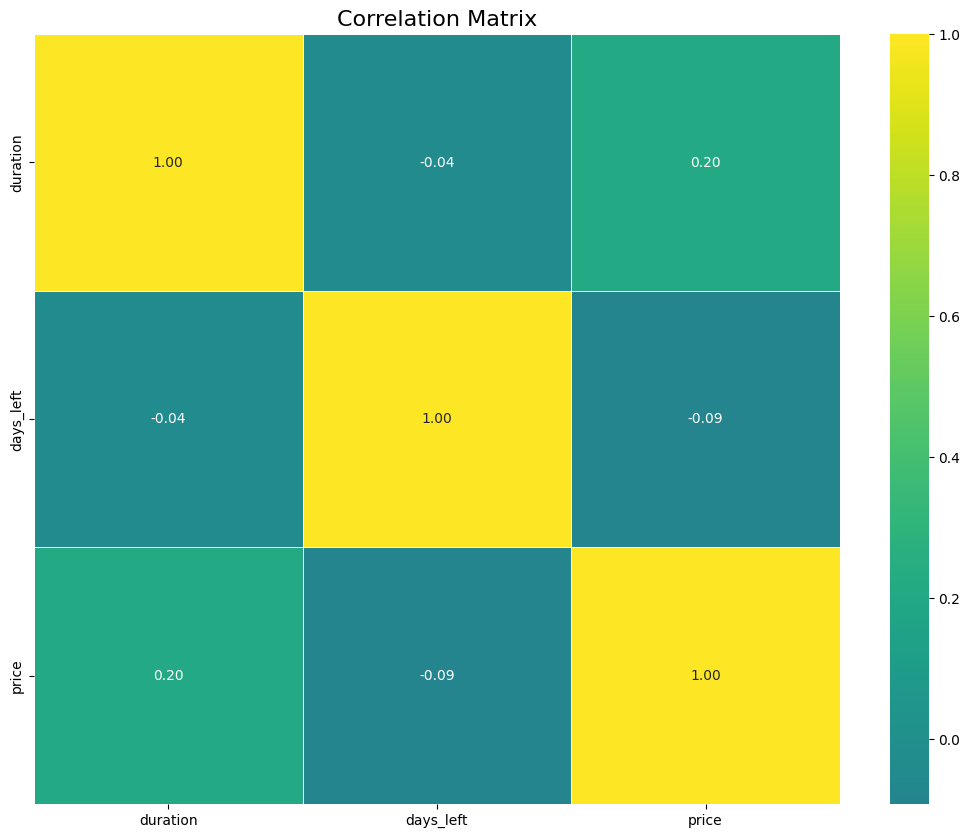

In [9]:
correlation_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(13, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0, fmt=".2f", linewidths=0.5, cbar=True)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

### ***Airline***

In [10]:
data['airline'].value_counts()

airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64

In [11]:
data.groupby('airline')['price'].mean().sort_values(ascending=False)

airline
Vistara      30396.536302
Air_India    23507.019112
SpiceJet      6179.278881
GO_FIRST      5652.007595
Indigo        5324.216303
AirAsia       4091.072742
Name: price, dtype: float64

The airlines Air_India and Vistara are the more expensive in price mean.

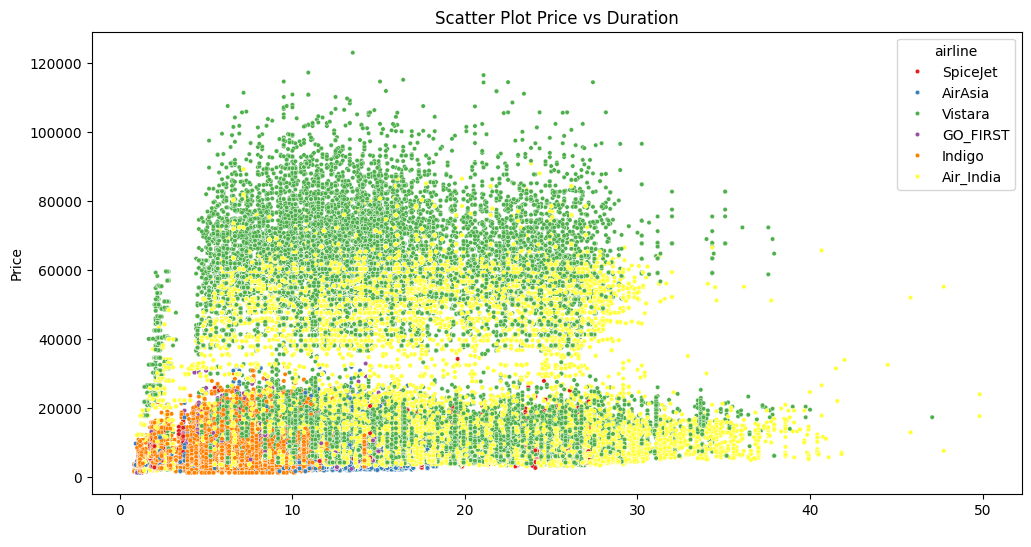

In [12]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='duration', y='price', hue='airline', data=data, palette='Set1',s=10)
plt.title('Scatter Plot Price vs Duration')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.show()

### ***Flight***

In [13]:
data['flight'].value_counts()

flight
UK-706     3235
UK-772     2741
UK-720     2650
UK-836     2542
UK-822     2468
           ... 
SG-9923       1
6E-6474       1
6E-865        1
G8-705        1
G8-107        1
Name: count, Length: 1561, dtype: int64

In [14]:
data.groupby('flight')['price'].mean()

flight
6E-102     2067.435897
6E-105     4079.000000
6E-113     5073.938776
6E-121     1702.000000
6E-123     6249.400000
              ...     
UK-988    37685.530775
UK-993    30494.012075
UK-994    36401.095837
UK-995    31270.540039
UK-996    38622.834913
Name: price, Length: 1561, dtype: float64

We have many different flights that would be very important to determine the price of the flight based on past prices for the same flight, but it is not convenient to have 1500 categories as an input variable.

### ***Source_city***

In [15]:
data['source_city'].value_counts()

source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64

In [16]:
data.groupby('source_city')['price'].mean()

source_city
Bangalore    21469.460575
Chennai      21995.339871
Delhi        18951.326639
Hyderabad    20155.623879
Kolkata      21746.235679
Mumbai       21483.818839
Name: price, dtype: float64

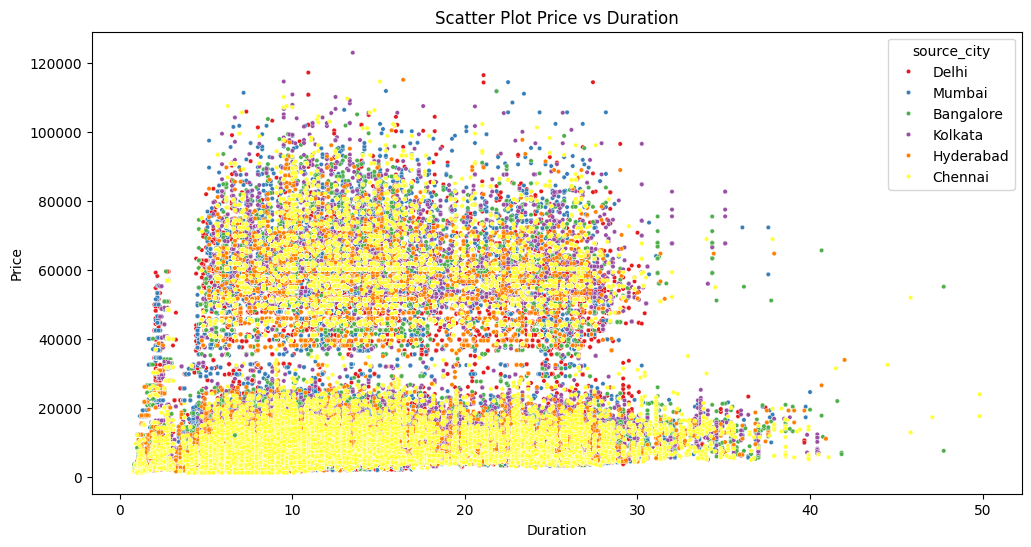

In [17]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='duration', y='price', hue='source_city', data=data, palette='Set1',s=10)
plt.title('Scatter Plot Price vs Duration')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.show()

There is a lot of uniformity between source_city and price.

### ***Departure_time***

In [18]:
data['departure_time'].value_counts()

departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: count, dtype: int64

In [19]:
data.groupby('departure_time')['price'].mean()

departure_time
Afternoon        18179.203331
Early_Morning    20370.676718
Evening          21232.361894
Late_Night        9295.299387
Morning          21630.760254
Night            23062.146808
Name: price, dtype: float64

Night flights are less frequent, but cheaper. On average, night flights are more expensive. The "departure_time" variable could be an important feature in determining the price.

### ***Stops***

In [20]:
data['stops'].value_counts()

stops
one            250863
zero            36004
two_or_more     13286
Name: count, dtype: int64

In [21]:
data.groupby('stops')['price'].mean()

stops
one            22900.992482
two_or_more    14113.450775
zero            9375.938535
Name: price, dtype: float64

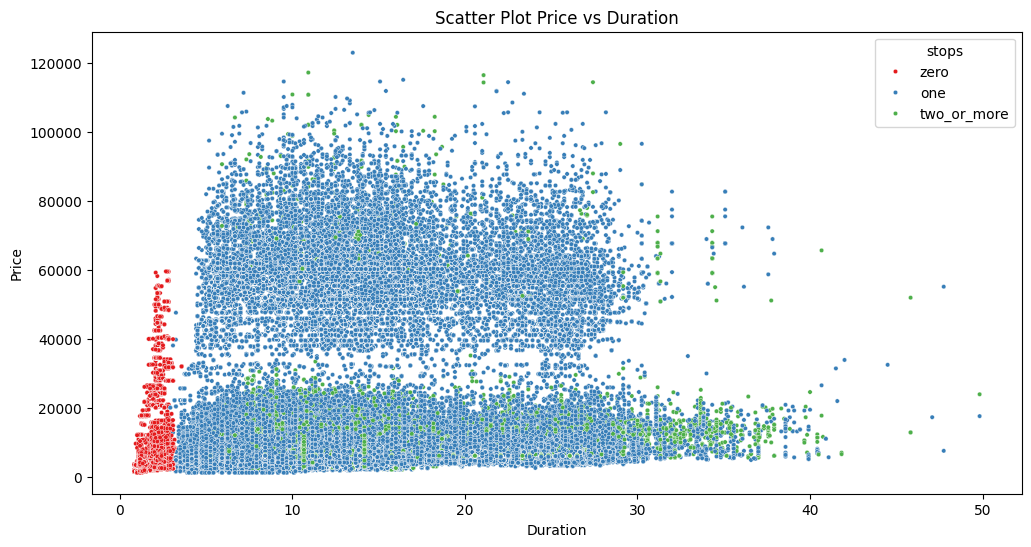

In [22]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='duration', y='price', hue='stops', data=data, palette='Set1',s=10)
plt.title('Scatter Plot Price vs Duration')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.show()

The flights that have at least one stop, they usually are more expensive.

### ***Arrival_time***

In [23]:
data['arrival_time'].value_counts()

arrival_time
Night            91538
Evening          78323
Morning          62735
Afternoon        38139
Early_Morning    15417
Late_Night       14001
Name: count, dtype: int64

In [24]:
data.groupby('arrival_time')['price'].mean().sort_values(ascending=False)

arrival_time
Evening          23044.371615
Morning          22231.076098
Night            21586.758341
Afternoon        18494.598993
Early_Morning    14993.139521
Late_Night       11284.906078
Name: price, dtype: float64

### ***Destination_city***

In [25]:
data['destination_city'].value_counts()

destination_city
Mumbai       59097
Delhi        57360
Bangalore    51068
Kolkata      49534
Hyderabad    42726
Chennai      40368
Name: count, dtype: int64

In [26]:
data.groupby('destination_city')['price'].mean().sort_values(ascending=False)

destination_city
Kolkata      21959.557556
Chennai      21953.323969
Bangalore    21593.955784
Mumbai       21372.529469
Hyderabad    20427.661284
Delhi        18436.767870
Name: price, dtype: float64

### ***Economy***

In [27]:
data['class'].value_counts()

class
Economy     206666
Business     93487
Name: count, dtype: int64

In [28]:
data.groupby('class')['price'].mean().sort_values(ascending=False)

class
Business    52540.081124
Economy      6572.342383
Name: price, dtype: float64

Clearly the class of flight is important to determine the price of the flight.

### ***Duration***

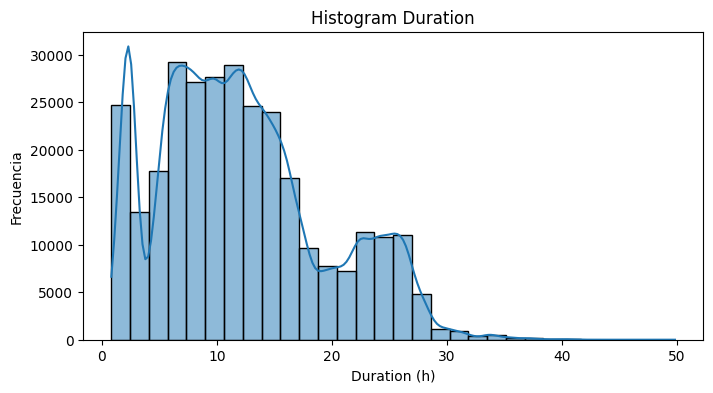

In [29]:
plt.figure(figsize=(8, 4))
sns.histplot(data['duration'], bins=30, kde=True)
plt.title('Histogram Duration')
plt.xlabel('Duration (h)')
plt.ylabel('Frecuencia')
plt.show()

In [30]:
data['duration'].describe()

count    300153.000000
mean         12.221021
std           7.191997
min           0.830000
25%           6.830000
50%          11.250000
75%          16.170000
max          49.830000
Name: duration, dtype: float64

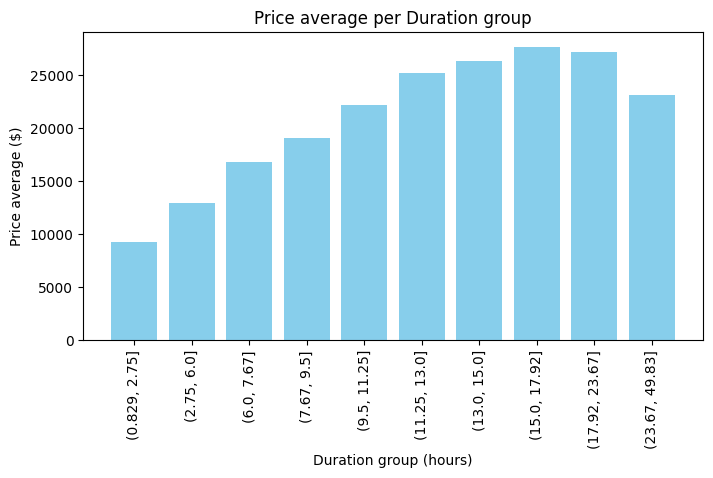

In [31]:
data['duration_group'] = pd.qcut(data['duration'], q=10, duplicates='drop')
grouped = data.groupby('duration_group')['price'].mean().reset_index()
grouped['duration_group'] = grouped['duration_group'].astype(str)
plt.figure(figsize=(8, 4))
plt.bar(grouped['duration_group'], grouped['price'], color='skyblue')
plt.title('Price average per Duration group')
plt.xlabel('Duration group (hours)')
plt.ylabel('Price average ($)')
plt.xticks(rotation=90)
plt.show()

Between 13 - 23.6 hours of flight duration the flight is more expensive.

### ***Days_left***

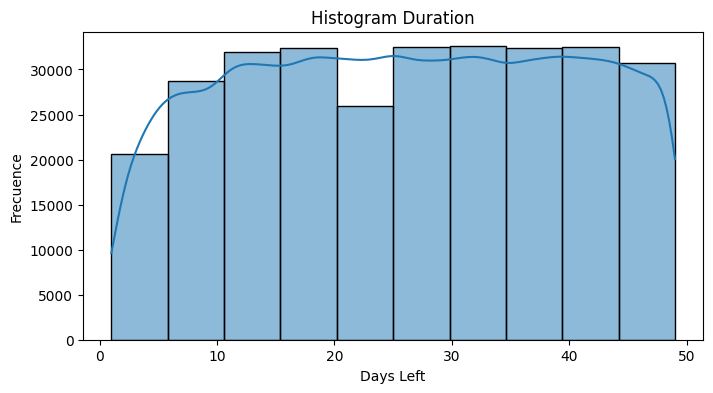

In [32]:
plt.figure(figsize=(8, 4))
sns.histplot(data['days_left'], bins=10, kde=True)
plt.title('Histogram Duration')
plt.xlabel('Days Left')
plt.ylabel('Frecuence')
plt.show()

In [33]:
data['days_left'].describe()

count    300153.000000
mean         26.004751
std          13.561004
min           1.000000
25%          15.000000
50%          26.000000
75%          38.000000
max          49.000000
Name: days_left, dtype: float64

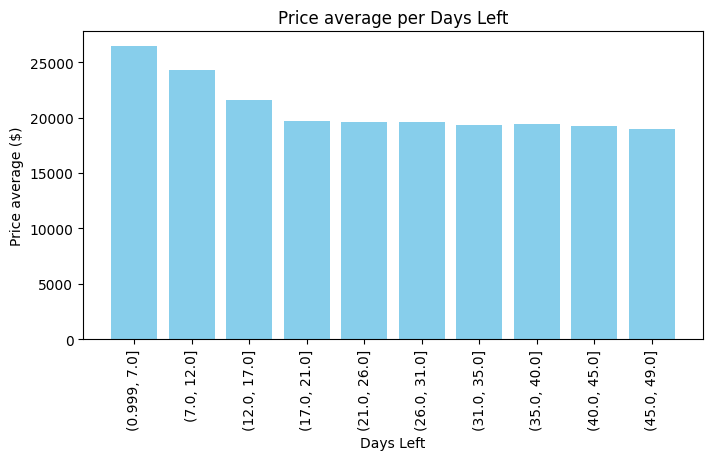

In [34]:
data['days_left_group'] = pd.qcut(data['days_left'], q=10, duplicates='drop')
grouped = data.groupby('days_left_group')['price'].mean().reset_index()
grouped['days_left_group'] = grouped['days_left_group'].astype(str)
plt.figure(figsize=(8, 4))
plt.bar(grouped['days_left_group'], grouped['price'], color='skyblue')
plt.title('Price average per Days Left')
plt.xlabel('Days Left')
plt.ylabel('Price average ($)')
plt.xticks(rotation=90)
plt.show()

In [35]:
data['days_left_group'].value_counts()

days_left_group
(21.0, 26.0]    32643
(35.0, 40.0]    32602
(26.0, 31.0]    32314
(40.0, 45.0]    32244
(0.999, 7.0]    32113
(12.0, 17.0]    31784
(7.0, 12.0]     30052
(17.0, 21.0]    26120
(31.0, 35.0]    25820
(45.0, 49.0]    24461
Name: count, dtype: int64

The greater the number of days, the lower the price of the ticket.

In [36]:
data['source-destin'] = data['source_city'] + '-' + data['destination_city']
data['source-destin'].value_counts()

source-destin
Delhi-Mumbai           15289
Mumbai-Delhi           14809
Delhi-Bangalore        14012
Bangalore-Delhi        13756
Bangalore-Mumbai       12939
Mumbai-Bangalore       12885
Mumbai-Kolkata         12602
Delhi-Kolkata          11934
Kolkata-Mumbai         11467
Delhi-Chennai          10780
Kolkata-Delhi          10506
Mumbai-Hyderabad       10470
Mumbai-Chennai         10130
Hyderabad-Mumbai       10064
Bangalore-Kolkata      10028
Kolkata-Bangalore       9824
Chennai-Delhi           9783
Chennai-Mumbai          9338
Delhi-Hyderabad         9328
Bangalore-Hyderabad     8928
Hyderabad-Delhi         8506
Hyderabad-Kolkata       7987
Kolkata-Hyderabad       7897
Hyderabad-Bangalore     7854
Chennai-Kolkata         6983
Kolkata-Chennai         6653
Chennai-Bangalore       6493
Bangalore-Chennai       6410
Hyderabad-Chennai       6395
Chennai-Hyderabad       6103
Name: count, dtype: int64

In [37]:
data.groupby('source-destin')['price'].mean().sort_values(ascending=False)

source-destin
Chennai-Bangalore      25081.850454
Kolkata-Chennai        23660.361040
Bangalore-Kolkata      23500.061229
Bangalore-Chennai      23321.850078
Mumbai-Bangalore       23147.873807
Bangalore-Mumbai       23128.618672
Mumbai-Chennai         22781.899112
Chennai-Mumbai         22765.849647
Kolkata-Bangalore      22744.808428
Chennai-Kolkata        22669.932407
Mumbai-Kolkata         22379.146723
Kolkata-Mumbai         22078.883579
Hyderabad-Chennai      21848.065989
Chennai-Hyderabad      21591.345404
Kolkata-Hyderabad      21500.011397
Hyderabad-Bangalore    21347.177998
Bangalore-Hyderabad    21226.121192
Mumbai-Hyderabad       21004.046705
Hyderabad-Kolkata      20823.893201
Delhi-Kolkata          20566.409418
Hyderabad-Mumbai       20080.865759
Kolkata-Delhi          19422.354559
Delhi-Chennai          19369.881354
Delhi-Mumbai           19355.829812
Chennai-Delhi          18981.863948
Mumbai-Delhi           18725.320008
Delhi-Bangalore        17880.216315
Bangalore-Delh

## ***Features Selection***

In [38]:
data1 = data[['airline','departure_time', 'stops', 'arrival_time', 'class', 'duration', 'days_left', 'price']]
data2 = data[['airline','source_city','departure_time', 'stops', 'arrival_time','destination_city', 'class', 'duration', 'days_left','price']]
data3 = data[['airline','stops','class','days_left','price']]
data4 = data[['airline','stops','class','days_left','price']]

### ***Data 1***

In [39]:
data1 = pd.get_dummies(data1, columns=['airline','departure_time', 'stops', 'arrival_time', 'class'], prefix=['airline','departure_time', 'stops', 'arrival_time', 'class'])
data1.head()

,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,departure_time_Afternoon,...,stops_two_or_more,stops_zero,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,class_Business,class_Economy
0,2.17,1,5953,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,True,False,True
1,2.33,1,5953,False,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,True
2,2.17,1,5956,True,False,False,False,False,False,False,...,False,True,False,True,False,False,False,False,False,True
3,2.25,1,5955,False,False,False,False,False,True,False,...,False,True,True,False,False,False,False,False,False,True
4,2.33,1,5955,False,False,False,False,False,True,False,...,False,True,False,False,False,False,True,False,False,True


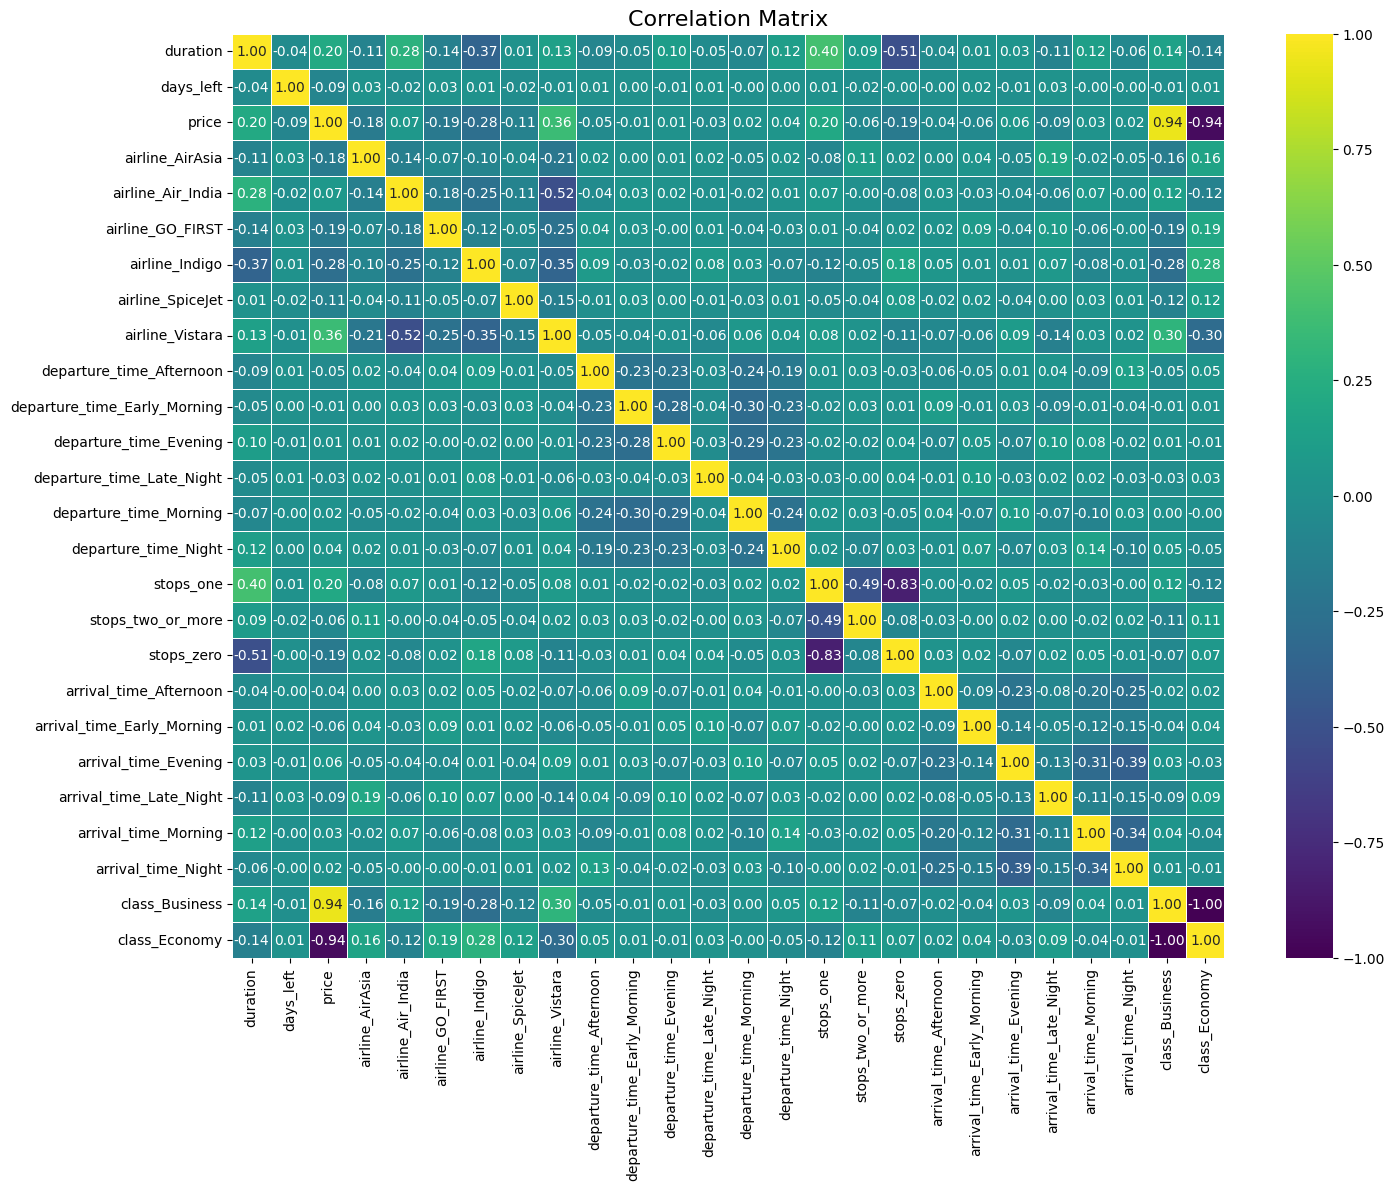

In [40]:
correlation_matrix = data1.corr(numeric_only=True)
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0, fmt=".2f", linewidths=0.5, cbar=True)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

### ***Data2***

In [41]:
data2 = pd.get_dummies(data2, columns=['airline','source_city','departure_time', 'stops', 'arrival_time','destination_city','class'], prefix=['airline','source_city','departure_time', 'stops', 'arrival_time','destination_city', 'class'])
data2.head()

,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Bangalore,...,arrival_time_Morning,arrival_time_Night,destination_city_Bangalore,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,class_Business,class_Economy
0,2.17,1,5953,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,True,False,True
1,2.33,1,5953,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,True,False,True
2,2.17,1,5956,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
3,2.25,1,5955,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,True
4,2.33,1,5955,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,True,False,True


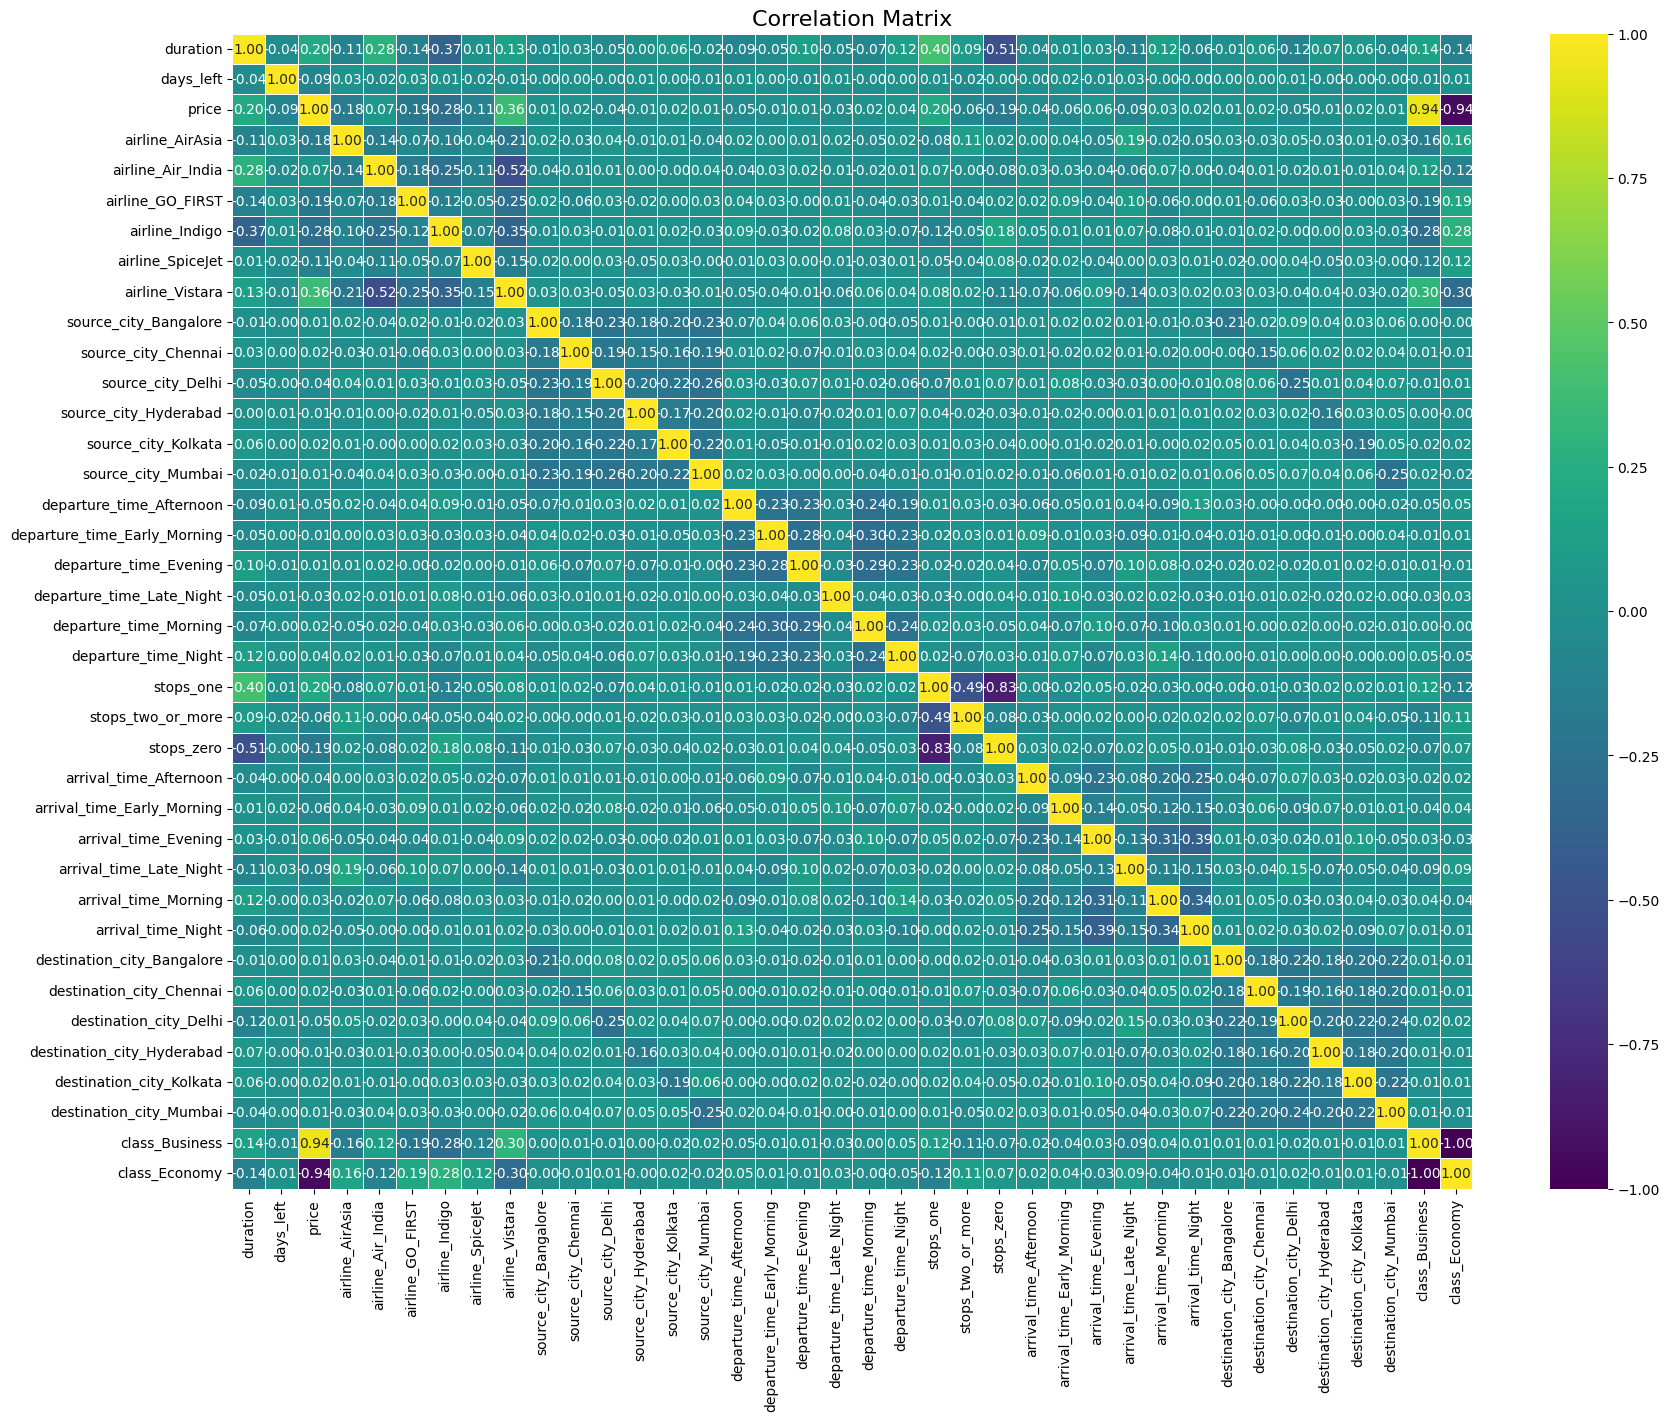

In [42]:
correlation_matrix = data2.corr(numeric_only=True)
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0, fmt=".2f", linewidths=0.5, cbar=True)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

### ***Data3***

In [43]:
data3 = pd.get_dummies(data3, columns=['airline','stops','class'], prefix=['airline','stops','class'])
data3.head()

,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,stops_one,stops_two_or_more,stops_zero,class_Business,class_Economy
0,1,5953,False,False,False,False,True,False,False,False,True,False,True
1,1,5953,False,False,False,False,True,False,False,False,True,False,True
2,1,5956,True,False,False,False,False,False,False,False,True,False,True
3,1,5955,False,False,False,False,False,True,False,False,True,False,True
4,1,5955,False,False,False,False,False,True,False,False,True,False,True


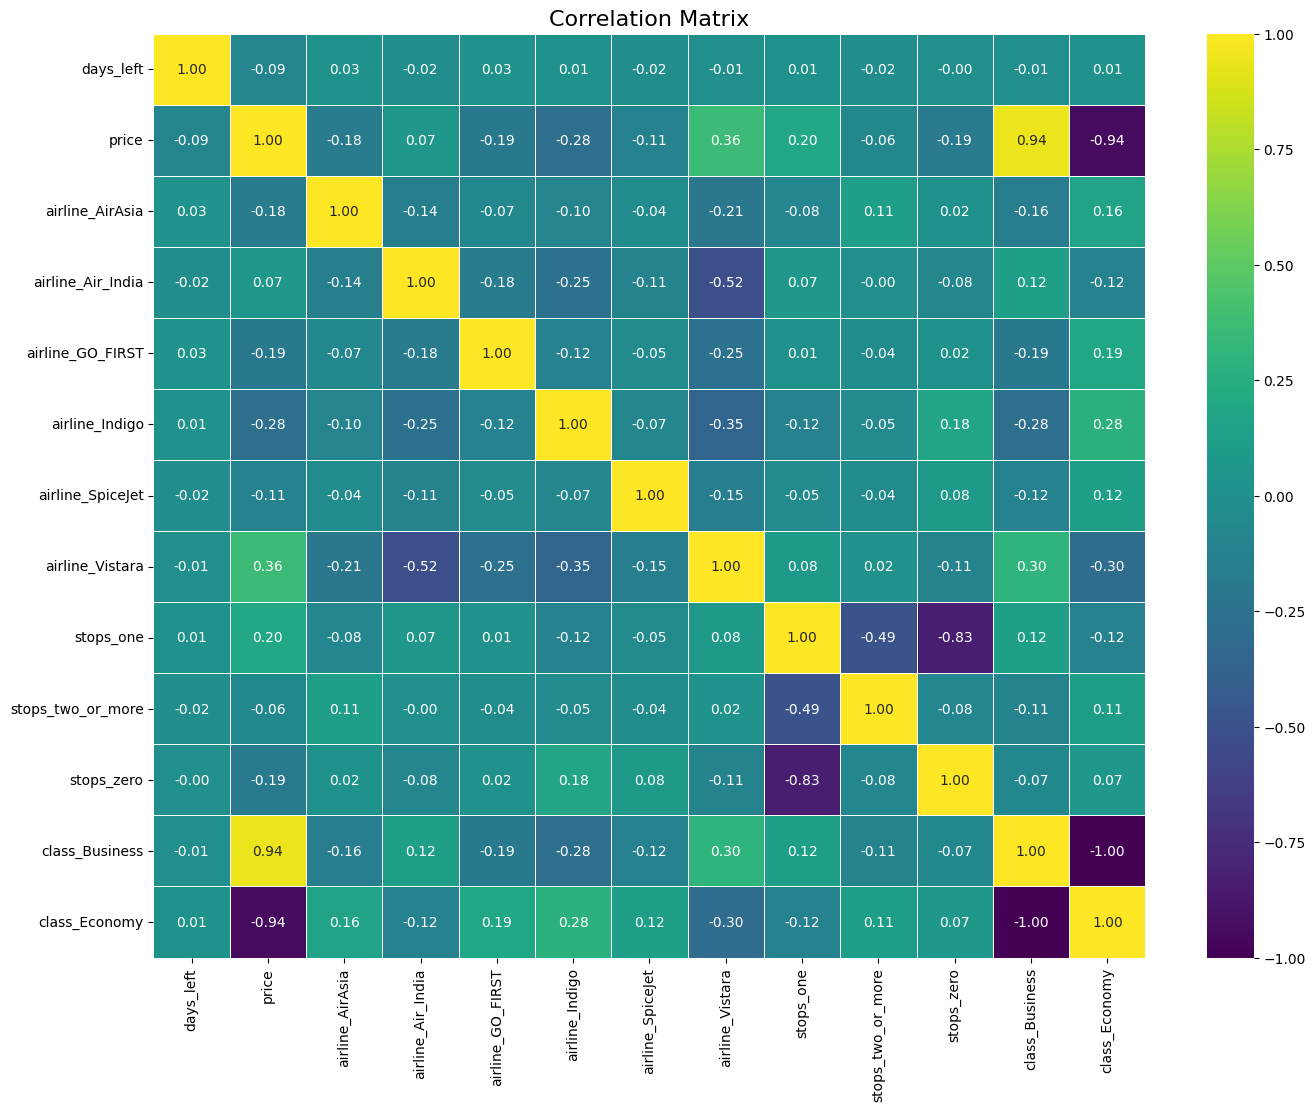

In [44]:
correlation_matrix = data3.corr(numeric_only=True)
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0, fmt=".2f", linewidths=0.5, cbar=True)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

### ***Data 4***

In [45]:
data4

,airline,stops,class,days_left,price
0,SpiceJet,zero,Economy,1,5953
1,SpiceJet,zero,Economy,1,5953
2,AirAsia,zero,Economy,1,5956
3,Vistara,zero,Economy,1,5955
4,Vistara,zero,Economy,1,5955
...,...,...,...,...,...
300148,Vistara,one,Business,49,69265
300149,Vistara,one,Business,49,77105
300150,Vistara,one,Business,49,79099
300151,Vistara,one,Business,49,81585


In [46]:
data4['airline'] = data4['airline'].replace({'Vistara':5, 'Air_India':4, 'SpiceJet':3, 'GO_FIRST':2, 'Indigo':1, 'AirAsia':0})
data4['stops'] = data4['stops'].replace({'one':2, 'two_or_more':1, 'zero':0 })
data4['class'] = data4['class'].replace({'Business':1,'Economy':0})

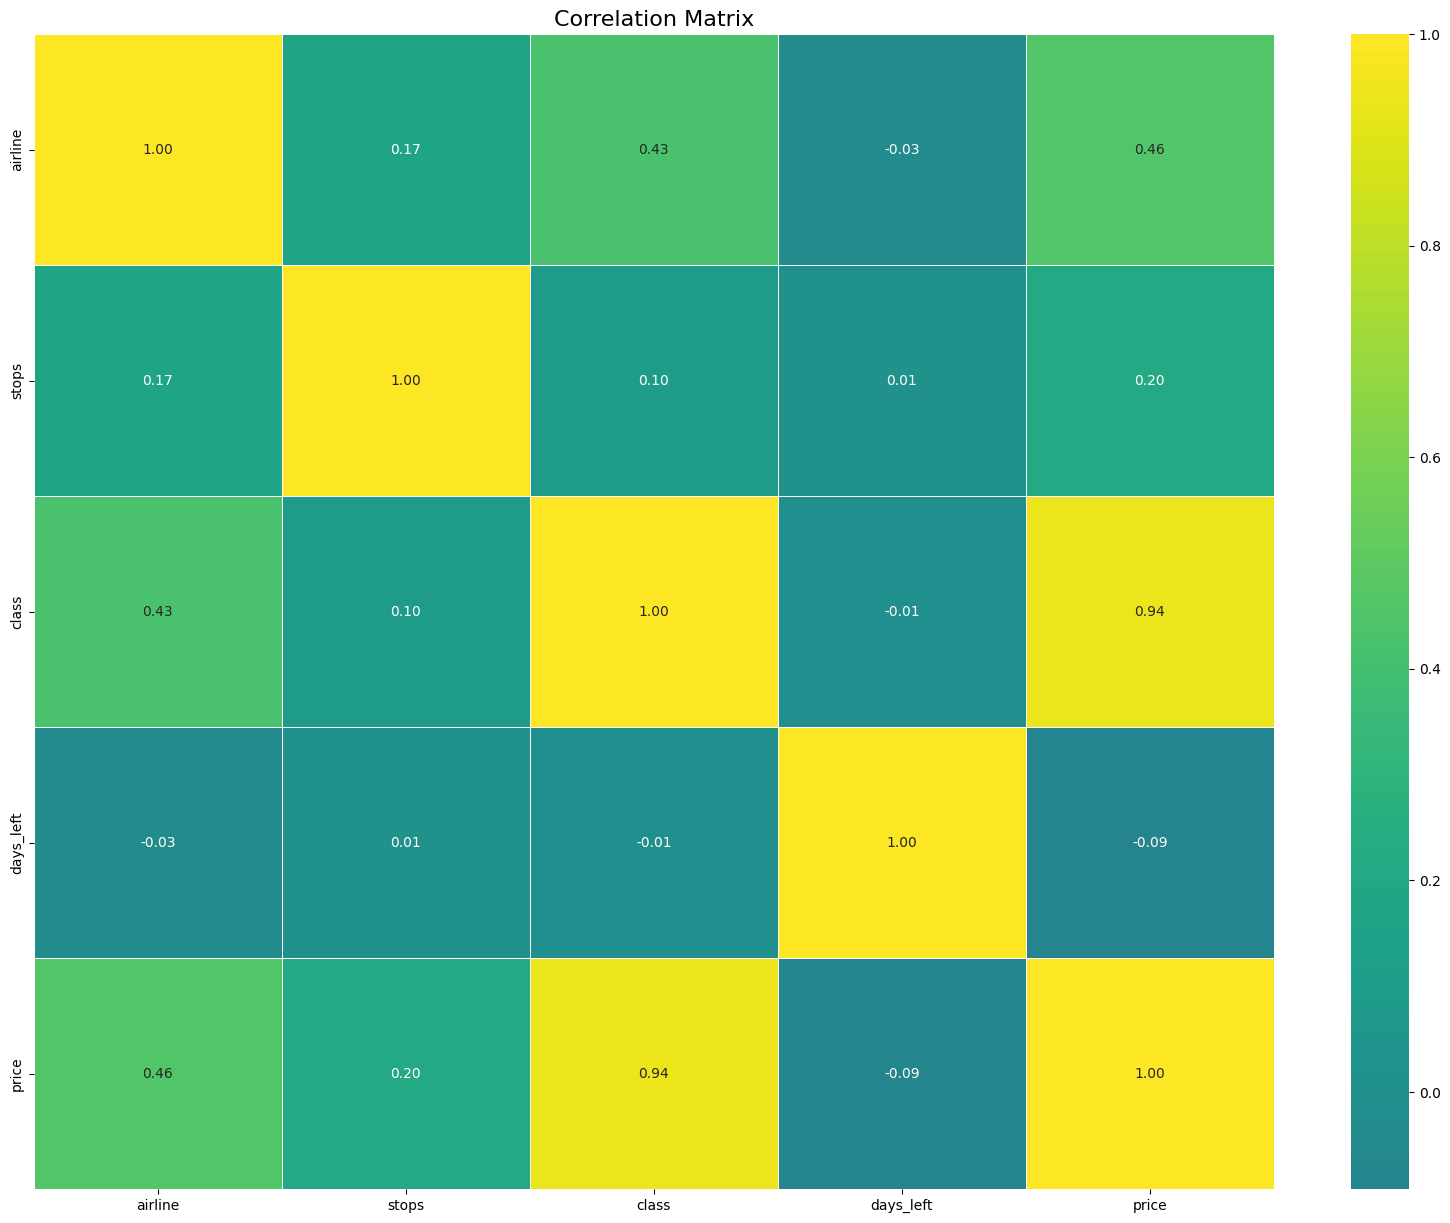

In [94]:
correlation_matrix = data4.corr(numeric_only=True)
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0, fmt=".2f", linewidths=0.5, cbar=True)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

## ***Model Train***

In [84]:
X = data2.drop(columns=['price'])
y = data2['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### ***Linear Regresion***

In [85]:
model1 = LinearRegression()
model1.fit(X_train, y_train)
y_pred_mod1 = model1.predict(X_test)

### ***XGBRegressor***

In [86]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=100)

In [87]:
xg_reg.fit(X_train, y_train)
y_pred_mod2 = xg_reg.predict(X_test)

### ***KNeighborsRegressor***

In [88]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [89]:
knn_regressor = KNeighborsRegressor(n_neighbors=4,weights='distance',algorithm='auto',p=2,metric='minkowski')
knn_regressor.fit(X_train_scaled, y_train)
y_pred_mod3 = knn_regressor.predict(X_test_scaled)

## ***Validation***

In [90]:
mse_1 = mean_squared_error(y_test, y_pred_mod1)
mae_1 = mean_absolute_error(y_test, y_pred_mod1)
mape_1 = mean_absolute_percentage_error(y_test,y_pred_mod1)
r2_1 = r2_score(y_test, y_pred_mod1)

In [91]:
mse_2 = mean_squared_error(y_test, y_pred_mod2)
mae_2 = mean_absolute_error(y_test, y_pred_mod2)
mape_2 = mean_absolute_percentage_error(y_test,y_pred_mod2)
r2_2 = r2_score(y_test, y_pred_mod2)

In [92]:
mse_3 = mean_squared_error(y_test, y_pred_mod3)
mae_3 = mean_absolute_error(y_test, y_pred_mod3)
mape_3 = mean_absolute_percentage_error(y_test,y_pred_mod3)
r2_3 = r2_score(y_test, y_pred_mod3)

In [93]:
# Resumen de las métricas obtenidas
modelo1_metrics = {'MSE': mse_1, 'MAE': mae_1, 'MAPE': mape_1, 'R2': r2_1}
modelo2_metrics = {'MSE': mse_2, 'MAE': mae_2, 'MAPE': mape_2, 'R2': r2_2}
modelo3_metrics = {'MSE': mse_3, 'MAE': mae_3, 'MAPE': mape_3, 'R2': r2_3}
df_metrics = pd.DataFrame([modelo1_metrics, modelo2_metrics, modelo3_metrics],
                          index=['Linear Regression', 'XGBRegressor', 'KNeighborsRegressor'])
df_metrics

,MSE,MAE,MAPE,R2
Linear Regression,4.572077e+07,4553.287817,0.462422,0.911305
XGBRegressor,2.120840e+07,2695.865015,0.186222,0.958857
KNeighborsRegressor,1.482324e+07,1750.933151,0.105380,0.971244


The comparative analysis of the regression models shows that the KNeighborsRegressor offers the best performance in terms of all the evaluated metrics. Specifically, it has the smallest mean square error (MSE) of 14,823,240, the smallest mean absolute error (MAE) of 1,750.93, and the smallest mean absolute percentage error (MAPE) of 0.105. Furthermore, it has the highest coefficient of determination (R²) of 0.971, indicating that it explains 97.1% of the variability in the data. In comparison, the and R² of 0.911. These results indicate that both XGBRegressor and KNeighborsRegressor greatly outperform linear regression, with KNeighborsRegressor offering the best overall accuracy.